# 0. What is Transfer Learning
Transfer learning is a machine learning technique where a pre-trained model, which has been trained on a large dataset, is reused as the starting point for a new task. Instead of training a model from scratch, you leverage the knowledge the pre-trained model has already learned, which can significantly reduce the amount of data and computational resources required for the new task. This is particularly useful in deep learning applications such as image classification, where models like VGG, ResNet, or Inception can be fine-tuned for specific tasks.

In [31]:
import torch
import torchvision

# Check if a GPU is available and use it, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [32]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


For this course we want 1.12+ and 0.13+.

Now let's import the codet we've written in the previous sections so that we don't have write it all again.

In [33]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import requests
from pathlib import Path
import zipfile

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine

1. Get data
We need the pizza, steak and sushi data to build a transfer learning model.

In [34]:

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print("Data already downloaded")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Data already downloaded


In [35]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `create_dataloaders()` function we made in 05. PyTorch going modular.

One thing to think about, when loading: How to **transform** it? With `torchvision` 0.13+ There are two ways to do it
1. Manually created transforms - you define what transforms you want the data to go through
2. Automatically created transforms - the transforms for the are data are defined by the model you'd like to use 

Important point: When using a pretrained model, it is important that the data (including the custom data) that you pass through it, is **transformed** in the same way, that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models, which are models for transfer learning, right within `torchvision`.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
> 
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.
> 
> You can use the following transform to normalize:
> `normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`
>
> Some pretrained models from torchvision.models in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't need to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.


In [36]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [37]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names
    

(<torch.utils.data.dataloader.DataLoader at 0x1fa9f06f0e0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transforms for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using

In [38]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default: Best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [39]:
# Get the transforms used to create the pretrained model
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [40]:
# Create dataloaders using automatic transforms 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fa9f06eab0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libs
2. Libs like `timm`
3. HuggingFace
4. Paperswithcode
5. ...

### 3.1 Which one to choose?

Experiment, experiment, ...

The whole idea of transfer learning: Take an already well-performing model from a problem space similar to my own and then customize to mu problem.

3 things to consider:
1. Speed
2. Size
3. Performance

Server? On device?

Mostly it becomes a trade-off.

For my case (FooVisionMini on mobile device), in looks like `EffNetB0` is one of the best options in terms of performance vs. size.

However, in light of The Bitter lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.

### 3.2 Setting up pretrained model

Want to create an instance of [`EffNetB0`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html).

In [41]:
# OLD way of creating a model (prior to PyTorch 0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [42]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

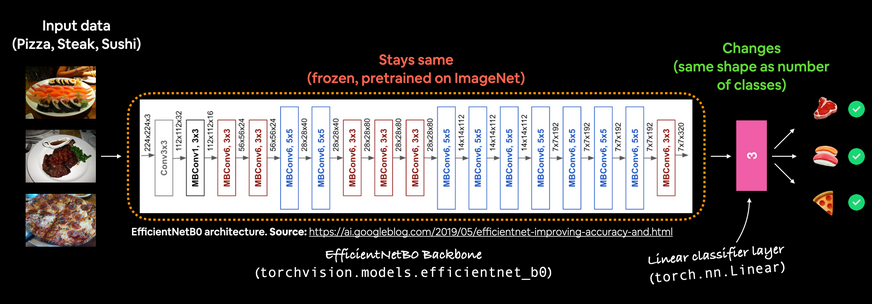
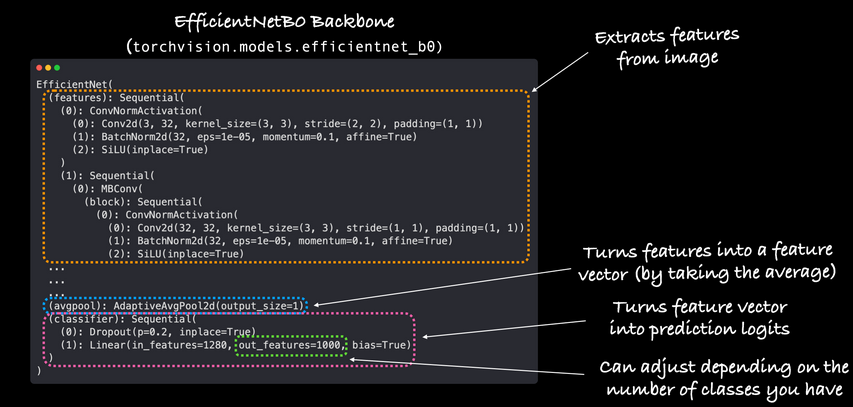
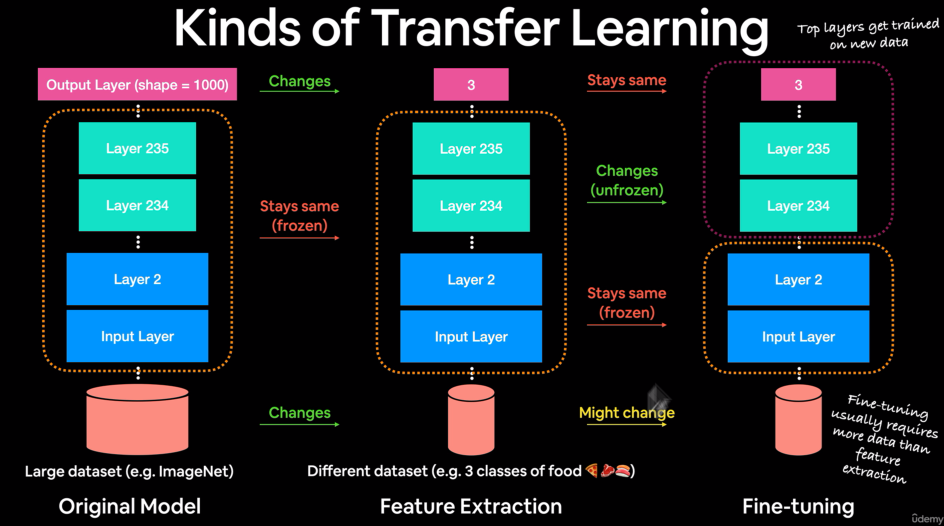

Our `efficientnet_b0` comes in three main parts:

- `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").
- `avgpool` - Takes the average of the output of the features layer(s) and turns it into a feature vector.
- `classifier` - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features`=1000 is the default).


### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [43]:
from torchinfo import summary

summary(
    model, 
    input_size=(1, 3, 224, 224),
    col_names=[
        "input_size", 
        "output_size", 
        "num_params", 
        "trainable"
        ],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will *freeze* the base layers of the pretrained/foundation model and update the output layers to suit the own problem.

In [44]:
# Freeze all base layers
for param in model.features.parameters():
    param.requires_grad = False

In [45]:
# Update classifier head of the model to suit the problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(
        1280, 
        len(class_names)
        ).to(device),
)

In [46]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [47]:
summary(
    model, 
    input_size=(1, 3, 224, 224),
    col_names=[
        "input_size", 
        "output_size", 
        "num_params", 
        "trainable"
        ],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [48]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
# Import train function from engine.py
from going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=25,
)

# End timer
end_time = timer()

print(f"Time taken: {end_time - start_time:.2f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5288 | train_acc: 0.9258 | test_loss: 0.5674 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4794 | train_acc: 0.9297 | test_loss: 0.5214 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4518 | train_acc: 0.9219 | test_loss: 0.5250 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.4759 | train_acc: 0.8398 | test_loss: 0.4815 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4073 | train_acc: 0.9570 | test_loss: 0.4943 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.4401 | train_acc: 0.8203 | test_loss: 0.4728 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.4078 | train_acc: 0.9453 | test_loss: 0.4559 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.4279 | train_acc: 0.8320 | test_loss: 0.4499 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5002 | train_acc: 0.8242 | test_loss: 0.4425 | test_acc: 0.8352
Epoch: 10 | train_loss: 0.4109 | train_acc: 0.8320 | test_loss: 0.3863 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.3490 | train_acc: 0.9453 | test_loss: 0.4120 | test_acc: 0.8456
Epoch: 12 | train_l

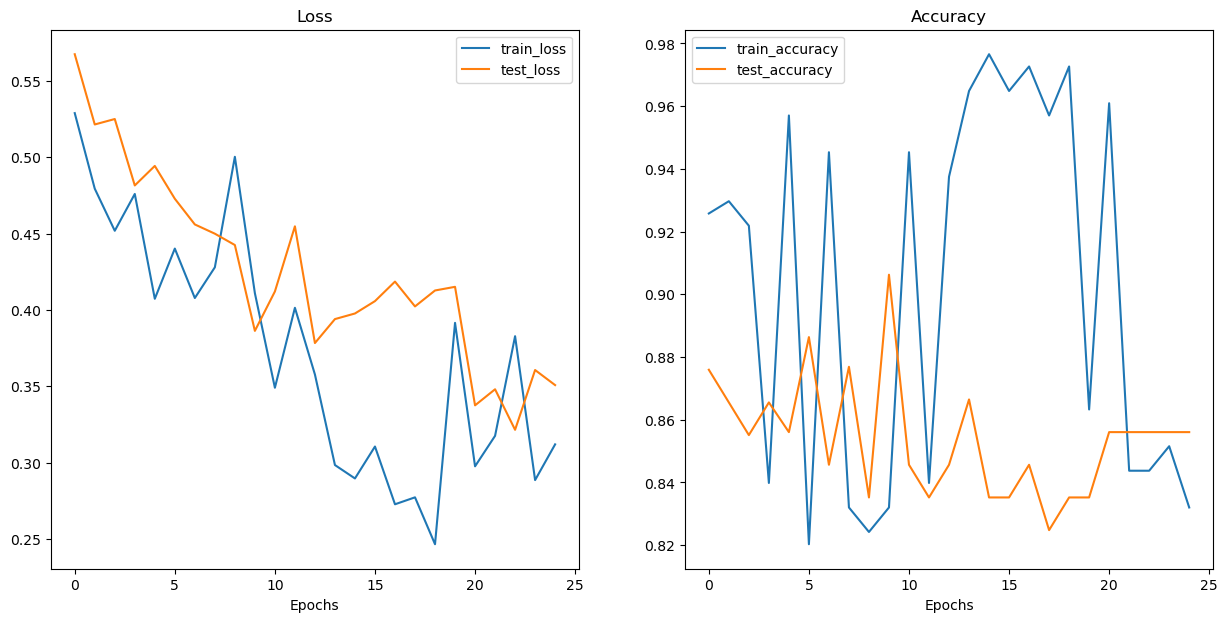

In [53]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(results)